In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

### Прочитайте базу "Потребление Энергии" (или BRENT(сделать анализ пропусков и больше чем 2-х дневные заполнить, и работаем для 3-х дневного ресемплинга), или COVID-19(выбрать любую страну кроме Бразилии)) и сделайте модель основных изменений по data_exp_1(сглаженной) с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
d_data = data.resample('D').mean()

d_data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-01,31080.739130,2002.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,1.0,0.0,0.0
2002-01-02,34261.541667,2002.0,1.0,2.0,1.0,2.0,1.0,2.0,11.5,0.0,0.0,1.0
2002-01-03,34511.875000,2002.0,1.0,3.0,1.0,3.0,1.0,3.0,11.5,0.0,0.0,0.0
2002-01-04,33715.458333,2002.0,1.0,4.0,1.0,4.0,1.0,4.0,11.5,0.0,0.0,0.0
2002-01-05,30405.125000,2002.0,1.0,5.0,1.0,5.0,1.0,5.0,11.5,0.0,0.0,0.0


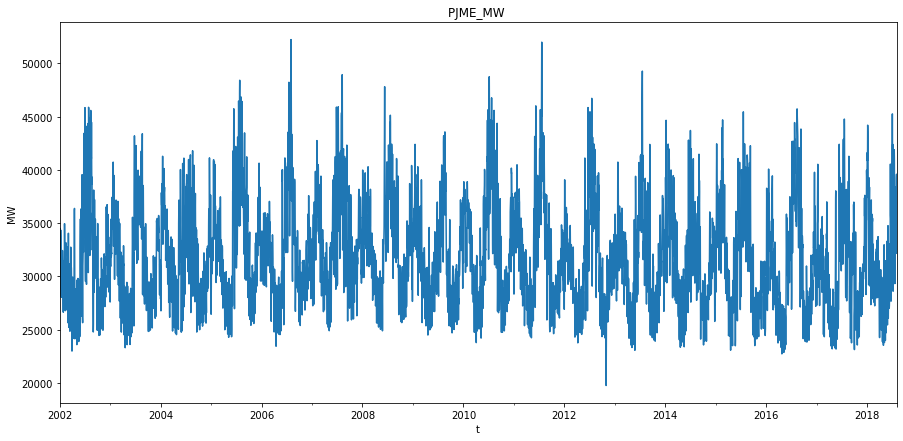

In [4]:
_ = d_data['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

In [5]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [6]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW'], 0.05)

Text(0.5, 1.0, 'PJME_MW')

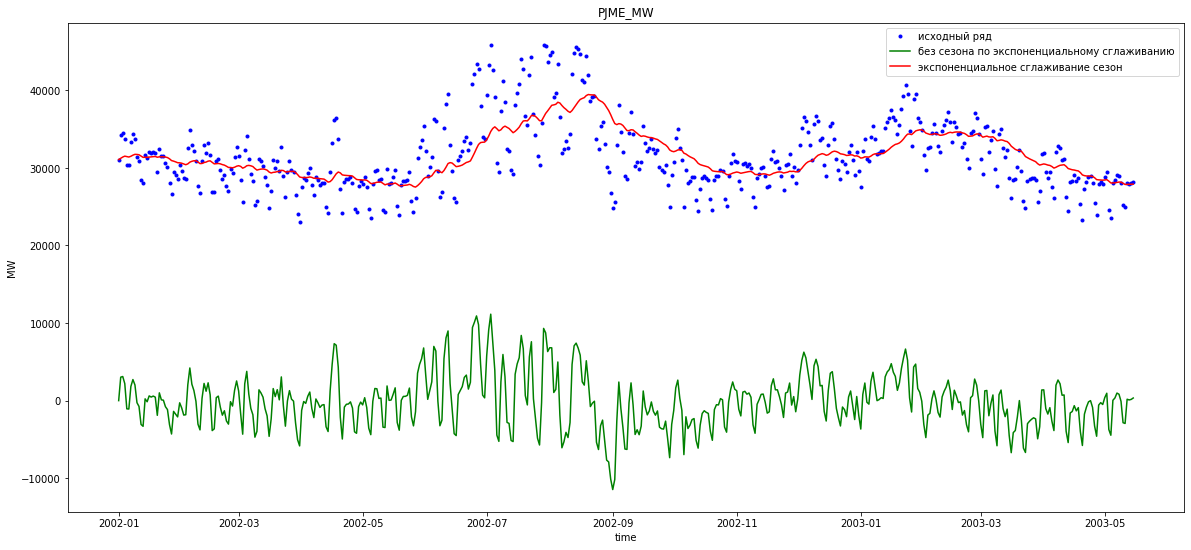

In [7]:
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [8]:
data_seson_free = pd.DataFrame(data = (np.array(d_data['PJME_MW']).reshape((d_data['PJME_MW'].shape[0],1)) -data_exp_1))
DF_ = sm.tsa.stattools.adfuller( data_seson_free.iloc[:,0] , regression = 'ctt')
DF_

(-8.365362138561908,
 4.2829746153967184e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

In [9]:
df = pd.DataFrame(data_exp_1, index = d_data.index)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0.0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0.0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0.0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0.0
df['diff1'].iloc[1:] = df.iloc[:-1,0].values-df.iloc[1:,0].values


df.head()

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31082.329532,31085.510334,31093.462341,-159.040127
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31085.540077,31095.046546,31118.256077,-163.604787
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31089.874554,31107.764782,31150.314611,-115.603714
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31093.608754,31118.430677,31175.353012,55.693138


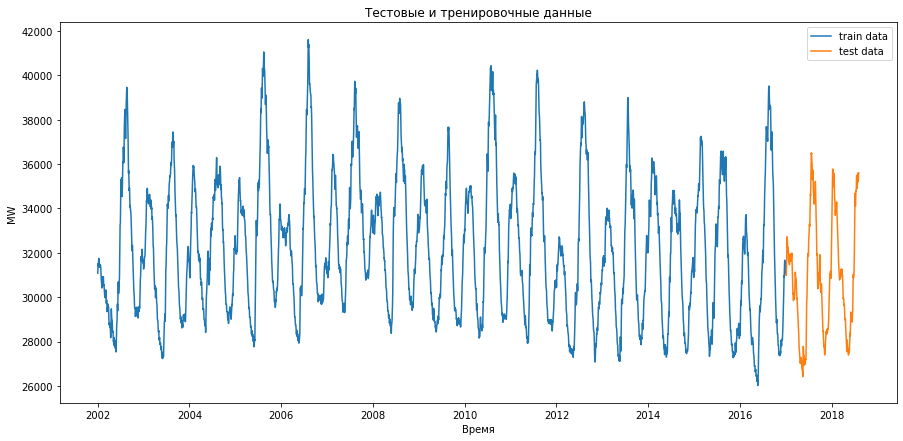

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

# сделаем примеры и модель 
def split_data_pjme( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train_pjme, test_pjme = split_data_pjme( df, '01-01-2017')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(train_pjme.index.get_level_values('Date'),train_pjme[df.columns[0]], label='train data' )
plt.plot(test_pjme.index.get_level_values('Date'),test_pjme[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

h = 1

In [11]:
h = 1

X_train_pjme_1 = train_pjme.iloc[:-h,:]
y_train_pjme_1 = train_pjme[df.columns[0]].values[h:]
X_test_pjme_1 = test_pjme.iloc[:-h,:]
y_test_pjme_1 = test_pjme[df.columns[0]].values[h:]

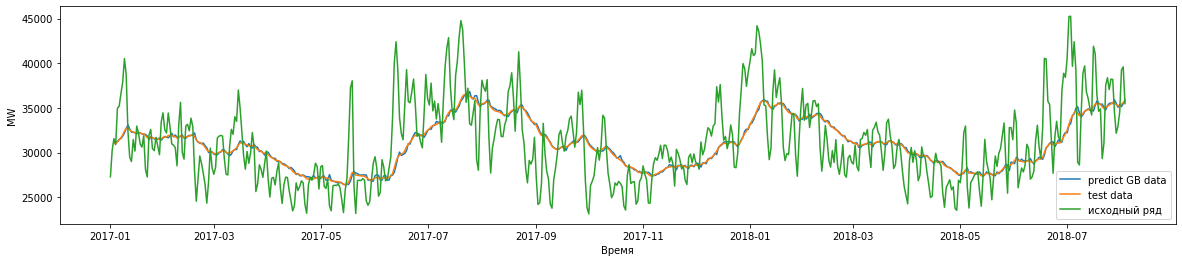

In [12]:
model_gb.fit( X_train_pjme_1, y_train_pjme_1 ) 
X_test_pred_gb_1 = model_gb.predict(X_test_pjme_1)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(test_pjme.index[h:],X_test_pred_gb_1, label='predict GB data' )
plt.plot(test_pjme.index[h:],y_test_pjme_1, label='test data')
plt.plot(d_data.loc['2017-01-01':].index, d_data.loc['2017-01-01':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

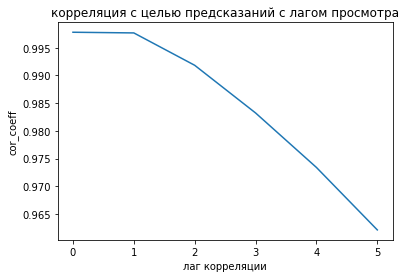

In [13]:
lag=5
p_cor_1=[np.corrcoef( y_test_pjme_1, X_test_pred_gb_1)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_pjme_1[:-(i+1)], X_test_pred_gb_1[(i+1):])[1,0]
    p_cor_1.append(c)    

plt.plot(np.array(p_cor_1) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

h = 10

In [14]:
h = 10

X_train_pjme_10 = train_pjme.iloc[:-h,:]
y_train_pjme_10 = train_pjme[df.columns[0]].values[h:]
X_test_pjme_10 = test_pjme.iloc[:-h,:]
y_test_pjme_10 = test_pjme[df.columns[0]].values[h:]

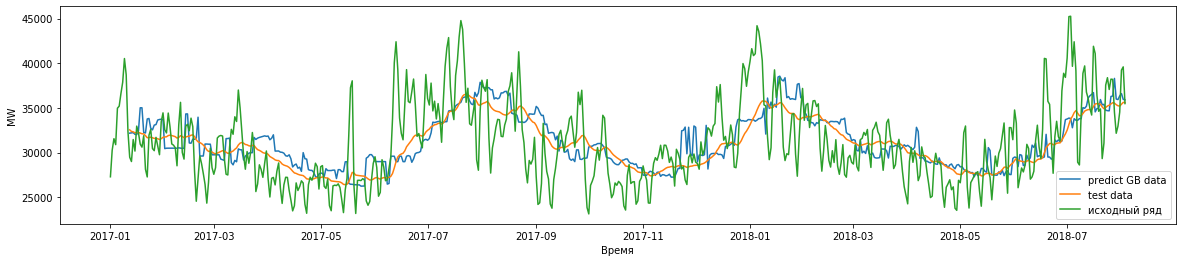

In [15]:
model_gb.fit( X_train_pjme_10, y_train_pjme_10 ) 
X_test_pred_gb_10 = model_gb.predict(X_test_pjme_10)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(test_pjme.index[h:],X_test_pred_gb_10, label='predict GB data' )
plt.plot(test_pjme.index[h:],y_test_pjme_10, label='test data')
plt.plot(d_data.loc['2017-01-01':].index, d_data.loc['2017-01-01':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

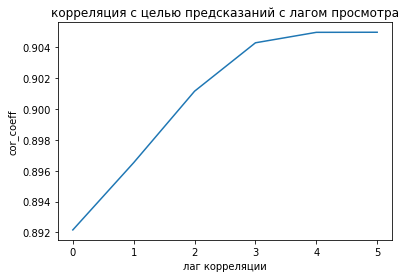

In [16]:
lag=5
p_cor_10=[np.corrcoef( y_test_pjme_10, X_test_pred_gb_10)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_pjme_10[:-(i+1)], X_test_pred_gb_10[(i+1):])[1,0]
    p_cor_10.append(c)    

plt.plot(np.array(p_cor_10) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

### Оцените ошибку модели из п.1 .

In [17]:
er_g = mean_absolute_percentage_error(y_true=y_test_pjme_1, y_pred=X_test_pred_gb_1)

print('ошибка градиентного бустинга h = 1:  ', er_g, '%')

ошибка градиентного бустинга h = 1:   0.4466592006637235 %


In [18]:
er_g = mean_absolute_percentage_error(y_true=y_test_pjme_10, y_pred=X_test_pred_gb_10)

print('ошибка градиентного бустинга h = 10:  ', er_g, '%')

ошибка градиентного бустинга h = 10:   3.3466983180348473 %


### Сделайте вывод о том, как изменилась ошибка модели по значениям h.

С увеличением горизонта прогноза растет ошибка

### Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).

б) Количество денег, которые тратят покупатели в интернет магазине.

в) Вес растущего котенка.

г) Прирост объема деревьев в лесу от времени

А - зависит от промежутка измерения, частоты измерения и случая. На отрезке менее 12 часов будет скорее всего стационарный ряд. На отрезке более 12 не стационарный. Появится тренд. Больше 2 суток добавится цикл. Больше полугода сезон.

Б - точно не стационарный. С трендом, сезоном и циклом. Сумма трат будет меняться в пределах недели. Явный суточный и недельный цикл. Летом и перед праздниками явно тратят больше, что даст сезон

В - не стационарный. С трендом на ротс в целом, но колебаниями веса зимой и летом, что даст сезон и цикл

Г - если анализируется фиксированная площадь с взрослым лесом, то ряд скорее всего будет стационарный из-за того, что лес булет обновляться, но без особого роста. Если же площадь не фиксирована, то не стационарный с трендом на рост. Явным сезоном и циклом роста